# Prueba de concepto de embedings de frases para calcular similaridad. Las recomendaciones se hacen en función de las overviews de las peliculas del dataset comparada con la overview de la pelicula que se da de input.

(7, 768)
[[ 1.00000012  0.18692753  0.28297687  0.29628235  0.27451009  0.10176252
   0.21696261]
 [ 0.18692753  1.          0.72058761  0.51428956  0.11749633  0.19306931
   0.66182351]
 [ 0.28297687  0.72058761  1.          0.48864418  0.2356894   0.17157131
   0.5599308 ]
 [ 0.29628235  0.51428956  0.48864418  0.99999976  0.26985481  0.37889442
   0.52388805]
 [ 0.27451009  0.11749634  0.23568939  0.2698549   0.99999988  0.23422125
  -0.01599788]
 [ 0.10176253  0.19306931  0.17157133  0.37889436  0.23422125  1.
   0.22319663]
 [ 0.21696261  0.66182351  0.5599308   0.52388799 -0.01599789  0.22319666
   1.        ]]


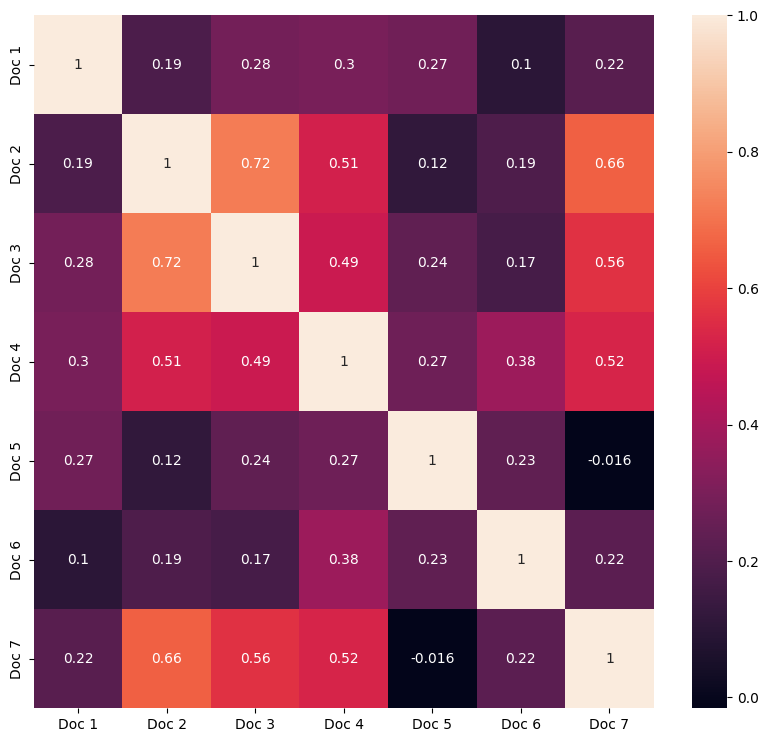

In [1]:
!pip install sentence_transformers
a = "purple is the best city in the forest"
b = "there is an art to getting your way and throwing bananas on to the street is not it"
c= "it is not often you find soggy bananas on the street"
d = "green should have smelled more tranquil but somehow it just tasted rotten"
e= "joyce enjoyed eating pancakes with ketchup"
f = "as the asteroid hurtled toward earth becky was upset her dentist appointment had been canceled"
g = "to get your way you must not bombard the road with yellow fruit"

from sentence_transformers import SentenceTransformer

model = SentenceTransformer('bert-base-nli-mean-tokens')

sentence_embeddings = model.encode([a, b, c, d, e, f, g])

print(sentence_embeddings.shape)

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Calculte similarities ( Will be stored in an array )
scores = np.zeros((sentence_embeddings.shape[0], sentence_embeddings.shape[0]))
for i in range(sentence_embeddings.shape[0]):
    scores[i, :] = cosine_similarity(
        [sentence_embeddings[i]],
        sentence_embeddings ) [0]

print(scores)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,9))
labels = ['Doc 1','Doc 2','Doc 3','Doc 4', 'Doc 5', 'Doc 6', 'Doc 7']
sim_map = sns.heatmap(scores, xticklabels = labels, yticklabels = labels, annot = True)

# Cargo el dataset de peliculas

In [2]:
import pandas as pd
df = pd.read_csv('movies_metadata.csv')

<ipython-input-2-eb29634ceff4>:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('movies_metadata.csv')


In [3]:
# Columna de overviews
film_overviews = df['overview'].tolist()


In [4]:
def calculate_similarity(input_sentence, document_embeddings):
    input_embedding = model.encode([input_sentence])
    scores = cosine_similarity(input_embedding, document_embeddings)[0]
    return scores

In [5]:
from sentence_transformers import SentenceTransformer# esta librería la usaré para calcular los embedings de los overviews

model = SentenceTransformer('bert-base-nli-mean-tokens')

In [6]:
!pip install gradio==4.14.0

In [22]:
df_subset = df
# Drop rows with null values in the 'overview' column
df_subset = df_subset.dropna(subset=['overview']).reset_index(drop=True)
# Gradio function to calculate similarity and return top 5 similar films
def find_similar_films(film_name):
    # Get the overview of the specified film
    overview = df_subset[df_subset['original_title'] == film_name]['overview'].values
    if len(overview) == 0 or pd.isna(overview[0]) or not isinstance(overview[0], str):
        return "Film overview not available or invalid."

    overview = overview[0]

    # Calculate similarity scores
    film_overview_embeddings = model.encode(df_subset['overview'])
    similarity_scores = calculate_similarity(overview, film_overview_embeddings)

    # Create a dataframe with film titles and their similarity scores
    result_df = pd.DataFrame({'Film': df_subset['original_title'], 'Similarity Score': similarity_scores})

    # Exclude the input film from the result
    result_df = result_df[result_df['Film'] != film_name]

    # Sort the dataframe by similarity scores in descending order
    result_df = result_df.sort_values(by='Similarity Score', ascending=False)

    # Select the top 5 films with the highest similarity scores
    top_5_films = result_df.head(5)

    # Return the top 5 similar films as a formatted string
    return "\n".join(top_5_films['Film'].tolist())

# Create Gradio Interface
iface = gr.Interface(fn=find_similar_films, inputs="text", outputs="text")

# Launch the Gradio interface
iface.launch()









Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://31af96df282892b79c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [21]:
find_similar_films('Toy Story')

'Honey I Blew Up the Kid\nUncle Buck\nPinocchio\nThe Toy\nJingle All the Way'